In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sko.PSO import PSO

In [3]:
data = pd.read_csv('Downloads/HousingData.csv')
X = data.drop(columns=['MEDV'])
y = data['MEDV']

n_lags = 5
num_cols = X.select_dtypes(include=[np.number]).columns

for i in range(1, n_lags + 1):
    for col in num_cols:
        X[f'{col}_lag{i}'] = X[col].shift(i)

In [4]:
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

scaler_y = MinMaxScaler()
y_scaled = pd.DataFrame(scaler_y.fit_transform(y.values.reshape(-1, 1)), columns=['MEDV'], index=y.index)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_imputed.select_dtypes(include=['float64', 'int64']).columns)
    ]
)

def create_pipeline(hidden_layer_size, activation_function, learning_rate, alpha, momentum):
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', MLPRegressor(hidden_layer_sizes=(hidden_layer_size,), activation=activation_function,
                                   learning_rate_init=learning_rate, alpha=alpha, momentum=momentum,
                                   max_iter=10000, random_state=42))
    ])

def objective_function(params):
    hidden_layer_size = int(params[0])
    learning_rate = params[1]
    alpha = params[2]
    momentum = params[3]
    activation_function = 'tanh' if params[4] < 0.5 else 'logistic'

    pipeline = create_pipeline(hidden_layer_size, activation_function, learning_rate, alpha, momentum)

    X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_scaled, test_size=0.2, random_state=42)

    pipeline.fit(X_train, y_train.values.ravel())
    y_pred = pipeline.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rmse

In [5]:
lb = [1, 0.0001, 1e-5, 0.5, 0]
ub = [50, 0.1, 1e-3, 0.99, 1]

pso = PSO(func=objective_function, n_dim=5, lb=lb, ub=ub, max_iter=200, pop=50, w=0.9, c1=0.6, c2=0.6, verbose=True)

In [6]:
best_params, best_value = pso.run()

Iter: 0, Best fit: [0.10076278] at [5.00000000e+01 3.09569189e-02 4.82705209e-04 9.53774598e-01
 8.66646728e-01]
Iter: 1, Best fit: [0.10076278] at [5.00000000e+01 3.09569189e-02 4.82705209e-04 9.53774598e-01
 8.66646728e-01]
Iter: 2, Best fit: [0.10076278] at [5.00000000e+01 3.09569189e-02 4.82705209e-04 9.53774598e-01
 8.66646728e-01]
Iter: 3, Best fit: [0.09767047] at [1.52747244e+01 2.93331172e-02 1.87593577e-05 8.15537777e-01
 1.00000000e+00]
Iter: 4, Best fit: [0.09629637] at [5.00000000e+01 7.29684235e-04 1.26248838e-04 9.90000000e-01
 1.00000000e+00]
Iter: 5, Best fit: [0.09376863] at [4.80464717e+00 1.27703621e-02 1.00000000e-05 9.90000000e-01
 1.00000000e+00]
Iter: 6, Best fit: [0.09376863] at [4.80464717e+00 1.27703621e-02 1.00000000e-05 9.90000000e-01
 1.00000000e+00]
Iter: 7, Best fit: [0.09376863] at [4.80464717e+00 1.27703621e-02 1.00000000e-05 9.90000000e-01
 1.00000000e+00]
Iter: 8, Best fit: [0.09376863] at [4.80464717e+00 1.27703621e-02 1.00000000e-05 9.90000000e-01


In [7]:
optimal_hidden_layer_size = int(best_params[0])
optimal_learning_rate = best_params[1]
optimal_alpha = best_params[2]
optimal_momentum = best_params[3]
optimal_activation_function = 'tanh' if best_params[4] < 0.5 else 'logistic'

print(f'Optimal Hidden Layer Size: {optimal_hidden_layer_size}')
print(f'Optimal Learning Rate: {optimal_learning_rate}')
print(f'Optimal Alpha: {optimal_alpha}')
print(f'Optimal Momentum: {optimal_momentum}')
print(f'Optimal Activation Function: {optimal_activation_function}')

Optimal Hidden Layer Size: 18
Optimal Learning Rate: 0.03682640692414271
Optimal Alpha: 0.0005057170427280122
Optimal Momentum: 0.825852396058439
Optimal Activation Function: logistic


In [8]:
final_pipeline = create_pipeline(optimal_hidden_layer_size, optimal_activation_function, optimal_learning_rate,
                                optimal_alpha, optimal_momentum)

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_scaled, test_size=0.2, random_state=42)

final_pipeline.fit(X_train, y_train.values.ravel())

y_train_pred_scaled = final_pipeline.predict(X_train)
y_test_pred_scaled = final_pipeline.predict(X_test)

y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

y_train_real = scaler_y.inverse_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_real = scaler_y.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

train_rmse = np.sqrt(mean_squared_error(y_train_real, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_real, y_test_pred))

print(f'Train Set RMSE: {train_rmse}')
print(f'Test Set RMSE: {test_rmse}')

Train Set RMSE: 3.3430374832910736
Test Set RMSE: 3.3531782879128382


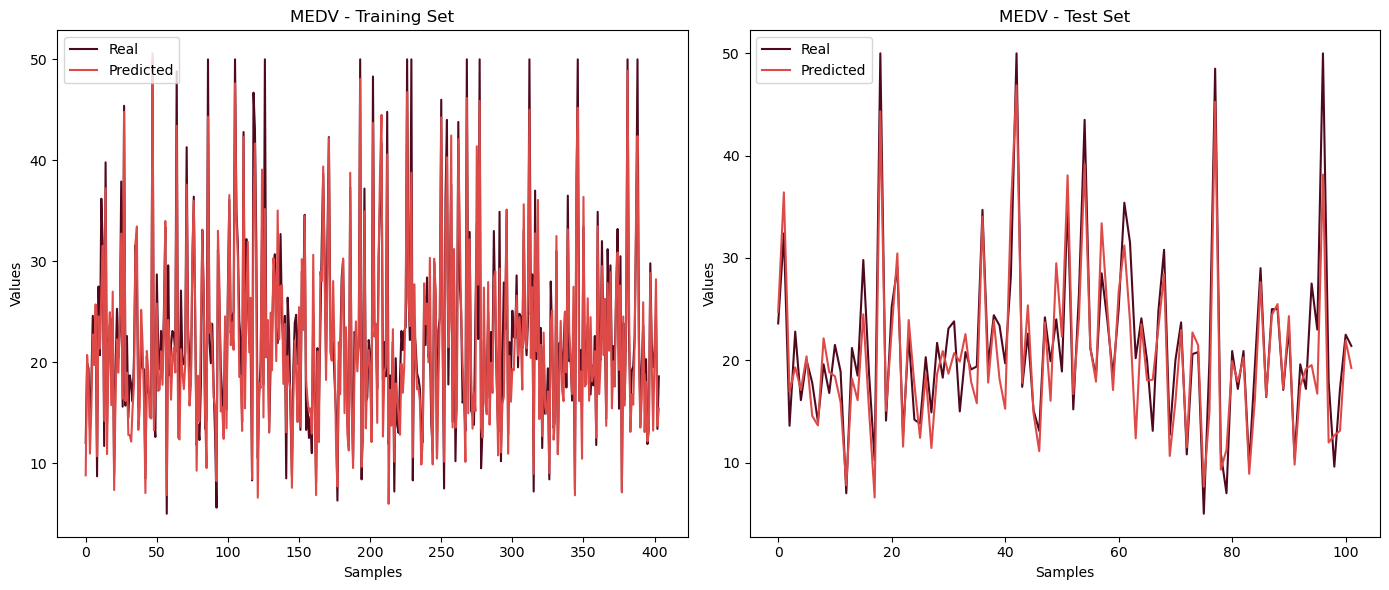

In [12]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(y_train_real, label='Real', color='#4F091D')
plt.plot(y_train_pred, label='Predicted', color='#DD4A48')
plt.title('MEDV - Training Set')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_test_real, label='Real', color='#4F091D')
plt.plot(y_test_pred, label='Predicted', color='#DD4A48')
plt.title('MEDV - Test Set')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()

plt.tight_layout()
plt.show()

In [2]:
final_pipeline = create_pipeline(optimal_hidden_layer_size, optimal_activation_function, optimal_learning_rate,
                                optimal_alpha, optimal_momentum)

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_scaled, test_size=0.2, random_state=42)

final_pipeline.fit(X_train, y_train.values.ravel())

y_train_pred_scaled = final_pipeline.predict(X_train)
y_test_pred_scaled = final_pipeline.predict(X_test)

y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

y_train_real = scaler_y.inverse_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_real = scaler_y.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

train_rmse = np.sqrt(mean_squared_error(y_train_real, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_real, y_test_pred))

print(f'Train Set RMSE: {train_rmse}')
print(f'Test Set RMSE: {test_rmse}')

los 2x0 esse fim de semana
99% de chance
gap mecanico de biartiti
~0.01 desvpad
